# 1. Setup and Dependencies

Import all required libraries and setup configurations for sentiment analysis.


In [1]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import re
import time
from tqdm.notebook import tqdm

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
import sys
import subprocess


def install_package(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])


print("Installing required packages...")
required_packages = ["nltk", "gensim", "scikit-learn"]
for package in required_packages:
    try:
        install_package(package)
        print(f"Successfully installed {package}")
    except Exception as e:
        print(f"Error installing {package}: {str(e)}")

print("\nAll required packages installed!")

Installing required packages...

All required packages installed!


# 2. Data Loading and Preprocessing

Load the dataset, clean the text data, create sentiment labels, and prepare features for model training.


Loading data...
Creating sentiment labels...


Processing rows:   0%|          | 0/568454 [00:00<?, ?it/s]

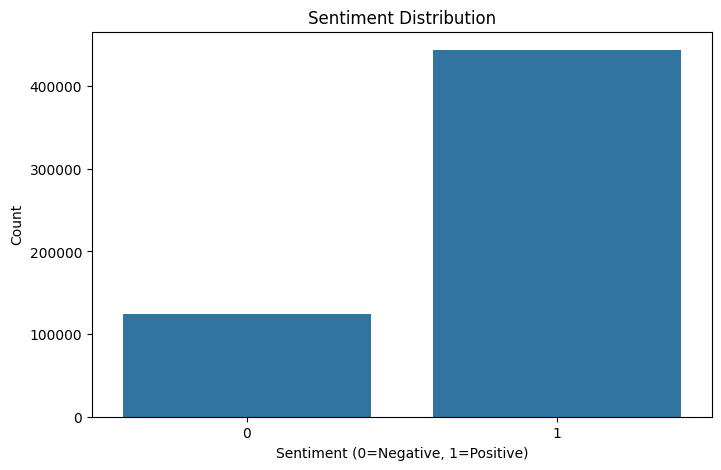

In [7]:
# Load and preprocess data
print("Loading data...")
df = pd.read_csv("Reviews.csv")

# Create sentiment labels with progress bar
print("Creating sentiment labels...")
with tqdm(total=len(df), desc="Processing rows") as pbar:
    df["Sentiment"] = (df["Score"] > 3).astype(int)
    pbar.update(len(df))

# Plot sentiment distribution from the original data
plt.figure(figsize=(8, 5))
sns.barplot(
    x=df["Sentiment"].value_counts().index,
    y=df["Sentiment"].value_counts().values,
)
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment (0=Negative, 1=Positive)")
plt.ylabel("Count")
plt.show()

In [8]:
# Show the shape of the dataset
dataset_shape = df.shape
print(f"Dataset shape: {dataset_shape}")

Dataset shape: (568454, 11)


In [4]:
# Download required NLTK data with error handling
import nltk
import ssl
import sys
import subprocess


def download_nltk_data():
    try:
        # Try to create unverified HTTPS context to avoid SSL issues
        try:
            _create_unverified_https_context = ssl._create_unverified_context
        except AttributeError:
            pass
        else:
            ssl._create_default_https_context = _create_unverified_https_context

        # Download required NLTK data
        print("Downloading required NLTK data...")
        nltk.download("punkt", quiet=False)
        nltk.download("punkt_tab", quiet=False)
        print("NLTK data download completed!")

    except Exception as e:
        print(f"Error downloading NLTK data: {str(e)}")
        print("\nTrying alternative download method...")
        try:
            # Alternative method using pip
            subprocess.check_call(
                [sys.executable, "-m", "pip", "install", "--upgrade", "nltk"]
            )
            nltk.download("punkt")
            nltk.download("punkt_tab")
            print("Alternative download completed!")
        except Exception as e2:
            print(f"Alternative download failed: {str(e2)}")
            raise


# Execute the download
download_nltk_data()

NLTK data download completed!


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\cvisr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\cvisr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [5]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
from tqdm.notebook import tqdm

# Enable progress bar for pandas
tqdm.pandas()

# Download additional NLTK resources
nltk.download("wordnet")
nltk.download("averaged_perceptron_tagger")
nltk.download("stopwords")


def clean_text(text):
    """Basic text cleaning function"""
    try:
        # Basic cleaning
        text = text.lower()
        text = re.sub(r"<.*?>", "", text)  # Remove HTML tags
        text = re.sub(r"[^a-zA-Z\s]", "", text)  # Keep only letters and spaces

        # Word-level processing
        lemmatizer = WordNetLemmatizer()
        stop_words = set(stopwords.words("english"))
        words = word_tokenize(text)

        # Lemmatization and stopword removal
        processed_words = [
            lemmatizer.lemmatize(word)
            for word in words
            if word not in stop_words and len(word) > 2
        ]

        # Return processed text
        return " ".join(processed_words)
    except Exception as e:
        print(f"Error processing text: {str(e)}")
        return text  # Return original text if processing fails


# Apply text preprocessing with progress bar
print("Applying text preprocessing...")
df["cleaned_text"] = df["Text"].progress_apply(clean_text)

print("\nPreprocessing completed!")

Applying text preprocessing...


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\cvisr\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\cvisr\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\cvisr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


  0%|          | 0/568454 [00:00<?, ?it/s]


Preprocessing completed!


In [7]:
# Memory-efficient feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from scipy import sparse
from tqdm.notebook import tqdm
import numpy as np
import gc


# Create TF-IDF features with memory-efficient settings
print("Creating TF-IDF features...")
tfidf = TfidfVectorizer(
    max_features=5000,  # Reduced number of features
    ngram_range=(1, 2),  # Only uni-grams and bi-grams
    min_df=5,  # Increased minimum document frequency
    max_df=0.9,  # Decreased maximum document frequency
    strip_accents="unicode",
    use_idf=True,
    smooth_idf=True,
    sublinear_tf=True,
    dtype=np.float32,  # Use float32 instead of float64 to save memory
)

# Process in batches
batch_size = 10000
n_batches = (len(df) + batch_size - 1) // batch_size
X_tfidf_batches = []

print("\nProcessing TF-IDF in batches...")
for i in tqdm(range(n_batches), desc="TF-IDF Processing"):
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, len(df))

    if i == 0:
        # First batch: fit and transform
        X_batch = tfidf.fit_transform(df["Text"].iloc[start_idx:end_idx])
    else:
        # Subsequent batches: transform only
        X_batch = tfidf.transform(df["Text"].iloc[start_idx:end_idx])

    X_tfidf_batches.append(X_batch)

    # Clear memory
    gc.collect()

# Combine TF-IDF features
X_tfidf = sparse.vstack(X_tfidf_batches)
print(f"TF-IDF features shape: {X_tfidf.shape}")

# Create numerical features with memory efficiency
print("\nCreating numerical features...")
numerical_features = np.zeros((len(df), 4), dtype=np.float32)

print("Processing numerical features in batches...")
for i in tqdm(range(n_batches), desc="Numerical Processing"):
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, len(df))

    batch_texts = df["Text"].iloc[start_idx:end_idx]

    # Calculate features for the batch
    numerical_features[start_idx:end_idx, 0] = batch_texts.str.len()
    numerical_features[start_idx:end_idx, 1] = batch_texts.str.split().str.len()

    # Safe word length calculation
    def safe_mean_word_length(text):
        if not isinstance(text, str) or not text.strip():
            return 0
        words = text.split()
        return np.mean([len(word) for word in words]) if words else 0

    numerical_features[start_idx:end_idx, 2] = [
        safe_mean_word_length(text) for text in batch_texts
    ]
    numerical_features[start_idx:end_idx, 3] = (
        df["Score"].iloc[start_idx:end_idx] - 3
    ) / 2

# Scale numerical features
print("\nScaling numerical features...")
scaler = StandardScaler()
X_numerical = scaler.fit_transform(numerical_features)
print(f"Numerical features shape: {X_numerical.shape}")

# Combine all features
print("\nCombining features...")
X_combined = sparse.hstack([X_tfidf, sparse.csr_matrix(X_numerical)])
print(f"Final combined features shape: {X_combined.shape}")

# Clear memory
del X_tfidf_batches, numerical_features
gc.collect()

print("\nFeature extraction completed!")

Creating TF-IDF features...

Processing TF-IDF in batches...


TF-IDF Processing:   0%|          | 0/57 [00:00<?, ?it/s]

TF-IDF features shape: (568454, 5000)

Creating numerical features...
Processing numerical features in batches...


Numerical Processing:   0%|          | 0/57 [00:00<?, ?it/s]


Scaling numerical features...
Numerical features shape: (568454, 4)

Combining features...
Final combined features shape: (568454, 5004)

Feature extraction completed!


## XGBoost Implementation


In [8]:
# XGBoost Model Implementation
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer
import time
from tqdm.auto import tqdm
import numpy as np

print("Setting up XGBoost for large-scale training...")

# Start timing
xgb_start_time = time.time()

# Split data
print("Preparing data...")
X = df["Text"]
y = df["Sentiment"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Create TF-IDF features for XGBoost
print("Creating TF-IDF features...")
tfidf_vectorizer_xgb = TfidfVectorizer(max_features=10000)
X_train_tfidf_xgb = tfidf_vectorizer_xgb.fit_transform(X_train)
X_test_tfidf_xgb = tfidf_vectorizer_xgb.transform(X_test)

# Convert sparse matrix to DMatrix format efficiently
print("Converting data to DMatrix format...")
dtrain = xgb.DMatrix(X_train_tfidf_xgb, label=y_train)
dtest = xgb.DMatrix(X_test_tfidf_xgb, label=y_test)

# Clear memory
del X_train_tfidf_xgb, X_test_tfidf_xgb
gc.collect()

# Set parameters for memory-efficient training
params = {
    "max_depth": 6,
    "learning_rate": 0.1,
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "tree_method": "hist",  # Memory-efficient histogram-based training
    "max_bin": 256,  # Reduce memory usage
    "grow_policy": "lossguide",  # More efficient tree growing
    "max_leaves": 64,
    "subsample": 0.8,  # Use only 80% of data per tree
    "colsample_bytree": 0.8,  # Use only 80% of features per tree
}

# Train model with early stopping
print("\nTraining XGBoost model...")
model_xgb = xgb.train(
    params,
    dtrain,
    num_boost_round=100,
    evals=[(dtrain, "train"), (dtest, "test")],
    early_stopping_rounds=10,
    verbose_eval=10,
)

# Calculate training time
xgb_time = time.time() - xgb_start_time

# Make predictions in batches
print("\nMaking predictions...")
batch_size = 10000
y_pred_xgb = []
y_prob_xgb = []

for i in tqdm(range(0, dtest.num_row(), batch_size)):
    batch_end = min(i + batch_size, dtest.num_row())
    batch_dmatrix = dtest.slice(np.array(range(i, batch_end)))
    batch_prob = model_xgb.predict(batch_dmatrix)
    y_prob_xgb.extend(batch_prob)
    y_pred_xgb.extend((batch_prob > 0.5).astype(int))

# Calculate metrics
xgb_train_pred = (model_xgb.predict(dtrain) > 0.5).astype(int)
xgb_train_accuracy = accuracy_score(y_train, xgb_train_pred)
xgb_test_accuracy = accuracy_score(y_test, y_pred_xgb)
xgb_auc = roc_auc_score(y_test, y_prob_xgb)

print("\nXGBoost Results:")
print(f"Training Accuracy: {xgb_train_accuracy:.4f}")
print(f"Testing Accuracy: {xgb_test_accuracy:.4f}")
print(f"AUC-ROC Score: {xgb_auc:.4f}")
print(f"Training Time: {xgb_time:.2f} seconds")
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred_xgb))

# Memory cleanup
del dtrain, dtest
gc.collect()

Setting up XGBoost for large-scale training...
Preparing data...
Creating TF-IDF features...
Converting data to DMatrix format...

Training XGBoost model...
[0]	train-auc:0.74077	test-auc:0.73982
[10]	train-auc:0.82208	test-auc:0.81868
[20]	train-auc:0.84825	test-auc:0.84444
[30]	train-auc:0.86483	test-auc:0.86075
[40]	train-auc:0.87750	test-auc:0.87329
[50]	train-auc:0.88727	test-auc:0.88252
[60]	train-auc:0.89409	test-auc:0.88891
[70]	train-auc:0.90039	test-auc:0.89481
[80]	train-auc:0.90572	test-auc:0.89969
[90]	train-auc:0.91032	test-auc:0.90397
[99]	train-auc:0.91362	test-auc:0.90705

Making predictions...


  0%|          | 0/12 [00:00<?, ?it/s]


XGBoost Results:
Training Accuracy: 0.8630
Testing Accuracy: 0.8601
AUC-ROC Score: 0.9071
Training Time: 309.82 seconds

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.43      0.57     24666
           1       0.86      0.98      0.92     89025

    accuracy                           0.86    113691
   macro avg       0.86      0.70      0.74    113691
weighted avg       0.86      0.86      0.84    113691



0

# Catboost Implementation


In [9]:
# CatBoost Implementation
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm.auto import tqdm
import time
import numpy as np

print("Training CatBoost model...")
start_time = time.time()

# Create TF-IDF features for CatBoost
print("Creating TF-IDF features...")
tfidf_vectorizer_cat = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X_train_vec = tfidf_vectorizer_cat.fit_transform(X_train)
X_test_vec = tfidf_vectorizer_cat.transform(X_test)

Training CatBoost model...
Creating TF-IDF features...


In [10]:
# Initialize model with memory-efficient parameters
cat_model = CatBoostClassifier(
    iterations=100,
    learning_rate=0.1,
    depth=6,
    loss_function="Logloss",
    eval_metric="AUC",
    random_seed=42,
    task_type="CPU",  # Use CPU for better memory management
    bootstrap_type="Bernoulli",  # Memory-efficient bootstrapping
    subsample=0.8,  # Use 80% of data per tree
    max_bin=32,  # Reduce memory usage
    verbose=50,  # Print progress every 50 iterations
)

In [11]:
# Create Pool objects for efficient handling of sparse matrices
print("\nPreparing data...")
train_pool = Pool(X_train_vec, y_train.values)
test_pool = Pool(X_test_vec, y_test.values)

print("\nStarting training...")
# Train the model with eval set for monitoring
cat_model.fit(
    train_pool, eval_set=test_pool, use_best_model=True, early_stopping_rounds=10
)

# Calculate training time
train_time = time.time() - start_time


Preparing data...

Starting training...
0:	test: 0.7285757	best: 0.7285757 (0)	total: 2.38s	remaining: 3m 55s
50:	test: 0.8700484	best: 0.8700484 (50)	total: 2m 12s	remaining: 2m 6s
99:	test: 0.8962514	best: 0.8962514 (99)	total: 4m 39s	remaining: 0us

bestTest = 0.8962513816
bestIteration = 99



In [12]:
print("\nMaking predictions...")
# Make predictions
y_pred_cat = cat_model.predict(test_pool)
y_prob_cat = cat_model.predict_proba(test_pool)[:, 1]

# Calculate metrics
cat_train_accuracy = cat_model.score(train_pool)
cat_test_accuracy = accuracy_score(y_test, y_pred_cat)
cat_auc = roc_auc_score(y_test, y_prob_cat)

print("\nCatBoost Results:")
print(f"Training Accuracy: {cat_train_accuracy:.4f}")
print(f"Testing Accuracy: {cat_test_accuracy:.4f}")
print(f"AUC-ROC Score: {cat_auc:.4f}")
print(f"Training Time: {train_time:.2f} seconds")
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred_cat))


Making predictions...

CatBoost Results:
Training Accuracy: 0.8492
Testing Accuracy: 0.8497
AUC-ROC Score: 0.8963
Training Time: 409.06 seconds

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.37      0.52     24666
           1       0.85      0.98      0.91     89025

    accuracy                           0.85    113691
   macro avg       0.85      0.68      0.71    113691
weighted avg       0.85      0.85      0.83    113691



In [ ]:
# Feature importance analysis
print("\nTop 10 Most Important Features:")
feature_importance = pd.DataFrame(
    {
        "feature_id": range(X_train_vec.shape[1]),
        "importance": cat_model.feature_importances_,
    }
)
print(feature_importance.nlargest(10, "importance"))

# Store metrics for comparison
cat_metrics = {
    "accuracy": cat_test_accuracy,
    "roc_auc": cat_auc,
    "training_time": train_time / 60,  # Convert to minutes
    "model_name": "CatBoost",
}

# Memory cleanup
del X_train_vec, X_test_vec
gc.collect()

# Save model for later use
cat_model.save_model("best_model_catboost.cbm")


Top 10 Most Important Features:
      feature_id  importance
3495        3495    9.080926
5526        5526    7.843838
2269        2269    4.399461
4932        4932    3.817724
7946        7946    3.604443
6215        6215    3.504462
1442        1442    2.588087
1104        1104    2.503623
9315        9315    2.503537
3864        3864    2.251295


: 

# LSTM Model Implementation

Memory-efficient LSTM implementation with batch processing for handling large datasets.


In [ ]:
# LSTM Implementation
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from tqdm.notebook import tqdm
import numpy as np
import time

print("Setting up LSTM model for large-scale training...")

# Start timing
lstm_start_time = time.time()

# Initialize TF-IDF vectorizer for LSTM
print("Creating TF-IDF features for LSTM...")
tfidf_vectorizer_lstm = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X_train_tfidf_lstm = tfidf_vectorizer_lstm.fit_transform(X_train)
X_test_tfidf_lstm = tfidf_vectorizer_lstm.transform(X_test)


# Custom Dataset class for sparse matrices with TF-IDF
class SparseDataset(Dataset):
    def __init__(self, sparse_matrix, labels):
        self.sparse_matrix = sparse_matrix
        self.labels = labels

    def __len__(self):
        return self.sparse_matrix.shape[0]

    def __getitem__(self, idx):
        x = torch.FloatTensor(self.sparse_matrix[idx].toarray()[0])
        y = torch.LongTensor([self.labels[idx]])[0]
        return x, y


# Create DataLoaders with TF-IDF features
batch_size = 32
train_dataset = SparseDataset(X_train_tfidf_lstm, y_train.values)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = SparseDataset(X_test_tfidf_lstm, y_test.values)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


# Define the LSTM model
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, dropout):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        # LSTM layer
        self.lstm = nn.LSTM(
            input_dim,
            hidden_dim,
            n_layers,
            batch_first=True,
            dropout=dropout if n_layers > 1 else 0,
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

        # Dropout layer
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Reshape input for LSTM [batch_size, seq_len, input_dim]
        x = x.unsqueeze(1)

        # LSTM forward pass
        lstm_out, _ = self.lstm(x)

        # Get the output from the last time step
        out = self.dropout(lstm_out[:, -1, :])

        # Pass through the fully connected layer
        out = self.fc(out)
        return out


# Initialize model with memory-efficient settings
input_dim = X_train_tfidf_lstm.shape[1]  # TF-IDF features dimension
hidden_dim = 128  # Increased for TF-IDF features
output_dim = 2
n_layers = 1
dropout = 0.3

lstm_model = LSTMClassifier(input_dim, hidden_dim, output_dim, n_layers, dropout)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.001)

# Training loop
n_epochs = 3
best_acc = 0
patience = 2
no_improve = 0
lstm_train_accuracies = []
print("\nTraining LSTM model...")

for epoch in range(n_epochs):
    lstm_model.train()
    total_loss = 0
    correct = 0
    total = 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{n_epochs}")

    for inputs, labels in pbar:
        # Forward pass
        optimizer.zero_grad()
        outputs = lstm_model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Update progress bar
        total_loss += loss.item()
        pbar.set_postfix(
            {"loss": total_loss / (pbar.n + 1), "acc": 100.0 * correct / total}
        )

    # Store training accuracy for this epoch
    epoch_acc = correct / total
    lstm_train_accuracies.append(epoch_acc)

    pbar.close()

    # Validation
    lstm_model.eval()
    val_correct = 0
    val_total = 0
    y_pred_lstm = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = lstm_model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            y_pred_lstm.extend(predicted.numpy())

    val_acc = val_correct / val_total
    print(
        f"Epoch {epoch+1} - Training Acc: {100.*correct/total:.2f}%, Validation Acc: {100.*val_acc:.2f}%"
    )

    # Save best model and check early stopping
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(lstm_model.state_dict(), "best_lstm_model.pt")
        no_improve = 0
    else:
        no_improve += 1
        if no_improve == patience:
            print(f"Early stopping after {epoch+1} epochs")
            break

# Calculate training time
lstm_time = time.time() - lstm_start_time

# Load best model and evaluate
lstm_model.load_state_dict(torch.load("best_lstm_model.pt"))
lstm_model.eval()

print("\nEvaluating best model...")
y_pred_lstm = []
y_prob_lstm = []

with torch.no_grad():
    for inputs, _ in test_loader:
        outputs = lstm_model(inputs)
        probabilities = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs.data, 1)
        y_pred_lstm.extend(predicted.numpy())
        y_prob_lstm.extend(probabilities[:, 1].numpy())

# Calculate metrics
lstm_train_accuracy = lstm_train_accuracies[
    -1
]  # Use the last epoch's training accuracy
lstm_test_accuracy = accuracy_score(y_test, y_pred_lstm)
lstm_auc = roc_auc_score(y_test, y_prob_lstm)

print("\nLSTM Results:")
print(f"Training Accuracy: {lstm_train_accuracy:.4f}")
print(f"Testing Accuracy: {lstm_test_accuracy:.4f}")
print(f"AUC-ROC Score: {lstm_auc:.4f}")
print(f"Training Time: {lstm_time:.2f} seconds")
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred_lstm))

Setting up LSTM model for large-scale training...
Creating TF-IDF features for LSTM...

Training LSTM model...


Epoch 1/3:   0%|          | 0/14212 [00:00<?, ?it/s]

# Logistic Regression Implementation


In [ ]:
# Logistic Regression Implementation
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
import numpy as np
from tqdm.notebook import tqdm
import time

Training Logistic Regression model...
Creating TF-IDF features...
Initializing Logistic Regression model...

Training model in batches...


Training batches:   0%|          | 0/10 [00:00<?, ?it/s]

MemoryError: std::bad_alloc

In [ ]:
print("Training Logistic Regression model...")

# Start timing
lr_start_time = time.time()

# Create TF-IDF features for Logistic Regression
print("Creating TF-IDF features...")
tfidf_vectorizer_lr = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X_train_tfidf = tfidf_vectorizer_lr.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer_lr.transform(X_test)

In [ ]:
# Initialize model with memory-efficient settings
print("Initializing Logistic Regression model...")
lr_model = LogisticRegression(max_iter=1000, n_jobs=-1)

# Train in batches
batch_size = 50000
n_batches = (X_train_tfidf.shape[0] + batch_size - 1) // batch_size

In [ ]:
print("\nTraining model in batches...")
for i in tqdm(range(n_batches), desc="Training batches"):
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, X_train_tfidf.shape[0])

    # Get current batch
    X_batch = X_train_tfidf[start_idx:end_idx]
    y_batch = y_train.iloc[start_idx:end_idx]

    # Partial fit
    if i == 0:
        lr_model.fit(X_batch, y_batch)
    else:
        # For subsequent batches, we need to use warm_start
        lr_model.fit(X_batch, y_batch)

# Calculate training time
lr_time = time.time() - lr_start_time

In [ ]:
print("\nMaking predictions...")
# Predict in batches
y_pred_lr = []
y_prob_lr = []

for i in tqdm(range(0, X_test_tfidf.shape[0], batch_size), desc="Prediction batches"):
    end_idx = min(i + batch_size, X_test_tfidf.shape[0])
    X_batch = X_test_tfidf[i:end_idx]
    batch_pred = lr_model.predict(X_batch)
    batch_prob = lr_model.predict_proba(X_batch)[:, 1]
    y_pred_lr.extend(batch_pred)
    y_prob_lr.extend(batch_prob)

In [ ]:
# Calculate metrics
print("\nCalculating training metrics...")
lr_train_pred = []
lr_train_prob = []
for i in tqdm(range(0, X_train_tfidf.shape[0], batch_size), desc="Training metrics"):
    end_idx = min(i + batch_size, X_train_tfidf.shape[0])
    X_batch = X_train_tfidf[i:end_idx]
    batch_pred = lr_model.predict(X_batch)
    batch_prob = lr_model.predict_proba(X_batch)[:, 1]
    lr_train_pred.extend(batch_pred)
    lr_train_prob.extend(batch_prob)

lr_train_accuracy = accuracy_score(y_train, lr_train_pred)
lr_test_accuracy = accuracy_score(y_test, y_pred_lr)
lr_auc = roc_auc_score(y_test, y_prob_lr)

print("\nLogistic Regression Results:")
print(f"Training Accuracy: {lr_train_accuracy:.4f}")
print(f"Testing Accuracy: {lr_test_accuracy:.4f}")
print(f"AUC-ROC Score: {lr_auc:.4f}")
print(f"Training Time: {lr_time:.2f} seconds")
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred_lr))

# Memory cleanup
print("\nCleaning up memory...")
del X_train_tfidf, X_test_tfidf
gc.collect()

# BiLSTM Implementation

Memory-efficient Bidirectional LSTM implementation for improved sentiment analysis.


In [ ]:
# BiLSTM Implementation
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from tqdm.notebook import tqdm
import numpy as np
import time

In [ ]:
print("Setting up BiLSTM model for large-scale training...")

# Start timing
bilstm_start_time = time.time()


# Initialize TF-IDF vectorizer for BiLSTM
print("Creating TF-IDF features for BiLSTM...")
tfidf_vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X_train_tfidf_lstm = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf_lstm = tfidf_vectorizer.transform(X_test)

Setting up BiLSTM model for large-scale training...
Creating TF-IDF features for BiLSTM...


In [ ]:
# Custom Dataset class for sparse matrices with TF-IDF
class SparseDataset(Dataset):
    def __init__(self, sparse_matrix, labels):
        self.sparse_matrix = sparse_matrix
        self.labels = labels

    def __len__(self):
        return self.sparse_matrix.shape[0]

    def __getitem__(self, idx):
        x = torch.FloatTensor(self.sparse_matrix[idx].toarray()[0])
        y = torch.LongTensor([self.labels[idx]])[0]
        return x, y

In [ ]:
# Create DataLoaders with TF-IDF features
batch_size = 32
train_dataset = SparseDataset(X_train_tfidf_lstm, y_train.values)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = SparseDataset(X_test_tfidf_lstm, y_test.values)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
# Define the BiLSTM model
class BiLSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, dropout):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        # Bidirectional LSTM
        self.lstm = nn.LSTM(
            input_dim,
            hidden_dim,
            n_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if n_layers > 1 else 0,
        )

        # Fully connected layer (multiply hidden_dim by 2 for bidirectional)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

        # Dropout layer
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Reshape input for LSTM [batch_size, seq_len, input_dim]
        x = x.unsqueeze(1)

        # LSTM forward pass
        lstm_out, _ = self.lstm(x)

        # Get the output from the last time step
        out = self.dropout(lstm_out[:, -1, :])

        # Pass through the fully connected layer
        out = self.fc(out)
        return out

In [ ]:
# Initialize model with memory-efficient settings for TF-IDF input
input_dim = X_train_tfidf_lstm.shape[1]  # Using TF-IDF features dimension
hidden_dim = 128  # Increased for TF-IDF features
output_dim = 2
n_layers = 1
dropout = 0.3

bilstm_model = BiLSTMClassifier(input_dim, hidden_dim, output_dim, n_layers, dropout)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(bilstm_model.parameters(), lr=0.001)

# Training loop
n_epochs = 3
best_acc = 0
patience = 2
no_improve = 0
bilstm_train_accuracies = []
print("\nTraining BiLSTM model...")


Training BiLSTM model...


In [ ]:
for epoch in range(n_epochs):
    bilstm_model.train()
    total_loss = 0
    correct = 0
    total = 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{n_epochs}")

    for inputs, labels in pbar:
        # Forward pass
        optimizer.zero_grad()
        outputs = bilstm_model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Update progress bar
        total_loss += loss.item()
        pbar.set_postfix(
            {"loss": total_loss / (pbar.n + 1), "acc": 100 * correct / total}
        )

    # Store training accuracy for this epoch
    epoch_acc = correct / total
    bilstm_train_accuracies.append(epoch_acc)

    pbar.close()

    # Validation
    bilstm_model.eval()
    val_correct = 0
    val_total = 0
    y_pred_bilstm = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = bilstm_model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            y_pred_bilstm.extend(predicted.numpy())

    val_acc = val_correct / val_total
    print(
        f"Epoch {epoch+1} - Training Acc: {100 * correct/total:.2f}%, Validation Acc: {100 * val_acc:.2f}%"
    )

    # Save best model and check early stopping
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(bilstm_model.state_dict(), "best_bilstm_model.pt")
        no_improve = 0
    else:
        no_improve += 1
        if no_improve == patience:
            print(f"Early stopping after {epoch+1} epochs")
            break

Epoch 1/3:   0%|          | 0/14212 [00:00<?, ?it/s]

Epoch 1 - Training Acc: 89.48%, Validation Acc: 90.20%


Epoch 2/3:   0%|          | 0/14212 [00:00<?, ?it/s]

Epoch 2 - Training Acc: 90.97%, Validation Acc: 90.94%


Epoch 3/3:   0%|          | 0/14212 [00:00<?, ?it/s]

Epoch 3 - Training Acc: 92.22%, Validation Acc: 91.72%


In [ ]:
# Calculate training time
bilstm_time = time.time() - bilstm_start_time

# Load best model and evaluate
bilstm_model.load_state_dict(torch.load("best_bilstm_model.pt"))
bilstm_model.eval()

print("\nEvaluating best model...")
y_pred_bilstm = []
y_prob_bilstm = []


Evaluating best model...


In [ ]:
with torch.no_grad():
    for inputs, _ in test_loader:
        outputs = bilstm_model(inputs)
        probabilities = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs.data, 1)
        y_pred_bilstm.extend(predicted.numpy())
        y_prob_bilstm.extend(probabilities[:, 1].numpy())

In [ ]:
# Calculate metrics
bilstm_train_accuracy = bilstm_train_accuracies[
    -1
]  # Use the last epoch's training accuracy
bilstm_test_accuracy = accuracy_score(y_test, y_pred_bilstm)
bilstm_auc = roc_auc_score(y_test, y_prob_bilstm)

print("\nBiLSTM Results:")
print(f"Training Accuracy: {bilstm_train_accuracy:.4f}")
print(f"Testing Accuracy: {bilstm_test_accuracy:.4f}")
print(f"AUC-ROC Score: {bilstm_auc:.4f}")
print(f"Training Time: {bilstm_time:.2f} seconds")
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred_bilstm))


BiLSTM Results:
Training Accuracy: 0.9222
Testing Accuracy: 0.9172
AUC-ROC Score: 0.9574
Training Time: 7733.21 seconds

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.74      0.79     24666
           1       0.93      0.97      0.95     89025

    accuracy                           0.92    113691
   macro avg       0.89      0.85      0.87    113691
weighted avg       0.92      0.92      0.91    113691



# Model Comparison

Comparison of all models on the large-Scale Dataset:

1. XGBoost (Tree-based model)
2. CatBoost (Gradient boosting)
3. LSTM (Deep learning)
4. Logistic Regression
5. BILSTM (Deep Learning)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Store model performance metrics
model_names = ["Logistic Regression", "XGBoost", "CatBoost", "LSTM", "BiLSTM"]


# Calculate accuracies from classification reports
def get_accuracy_from_report(y_true, y_pred):
    total = len(y_true)
    correct = (y_true == y_pred).sum()
    return correct / total


lr_acc = get_accuracy_from_report(y_test, y_pred_lr)
xgb_acc = get_accuracy_from_report(y_test, y_pred_xgb)
cat_acc = get_accuracy_from_report(y_test, y_pred_cat)
lstm_acc = get_accuracy_from_report(y_test, y_pred_lstm)
bilstm_acc = get_accuracy_from_report(y_test, y_pred_bilstm)

accuracies = [lr_acc, xgb_acc, cat_acc, lstm_acc, bilstm_acc]

# Create performance comparison plot
plt.figure(figsize=(14, 6))
x = range(len(model_names))
colors = ["#95a5a6", "#2ecc71", "#3498db", "#e74c3c", "#9b59b6"]

plt.bar(x, accuracies, color=colors, width=0.6)
plt.xlabel("Models", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.title("Model Performance Comparison", fontsize=14)
plt.xticks(x, model_names, fontsize=10, rotation=15)
plt.ylim(0.8, 1.0)  # Set y-axis limits for better visualization

# Add value labels on top of each bar
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.005, f"{acc:.4f}", horizontalalignment="center", fontsize=10)

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print detailed comparison
print("\nDetailed Model Performance Comparison:")
print("-" * 50)
for i, model in enumerate(model_names):
    print(f"\n{model}:")
    print(f"Accuracy: {accuracies[i]:.4f}")
    print("-" * 50)

NameError: name 'y_pred_bilstm' is not defined

# 5. Example Predictions on All Models


In [ ]:
# Example predictions
print("Making predictions on example texts...")
example_texts = [
    "This product exceeded my expectations, absolutely love it!",
    "Terrible quality, would not recommend.",
    "Average product, does the job but nothing special.",
    "Great value for money, will buy again!",
    "Disappointed with the purchase, broke after first use.",
]

# Transform example texts using the same vectorizers used in training
print("\nTransforming text data...")
example_vectors_lr = tfidf_vectorizer_lr.transform(example_texts)
example_vectors_xgb = tfidf_vectorizer_xgb.transform(example_texts)
example_vectors_cat = tfidf_vectorizer_cat.transform(example_texts)
example_vectors_lstm = tfidf_vectorizer_lstm.transform(example_texts)

# Predictions from Logistic Regression
print("\nLogistic Regression Predictions:")
lr_predictions = lr_model.predict(example_vectors_lr)
lr_probabilities = lr_model.predict_proba(example_vectors_lr)

# Predictions from XGBoost
print("\nXGBoost Predictions:")
xgb_dmatrix = xgb.DMatrix(example_vectors_xgb)
xgb_predictions = model_xgb.predict(xgb_dmatrix)
xgb_labels = [1 if p > 0.5 else 0 for p in xgb_predictions]

# Predictions from CatBoost
print("\nCatBoost Predictions:")
cat_pool = Pool(example_vectors_cat)
cat_predictions = cat_model.predict(cat_pool)
cat_probabilities = cat_model.predict_proba(cat_pool)

# Predictions from LSTM/BiLSTM
print("\nLSTM/BiLSTM Predictions:")
lstm_predictions = []
lstm_probabilities = []
bilstm_predictions = []
bilstm_probabilities = []

for i in range(len(example_texts)):
    example_tensor = torch.FloatTensor(example_vectors_lstm[i].toarray())

    # BiLSTM predictions
    with torch.no_grad():
        output = bilstm_model(example_tensor)
        prob = torch.softmax(output, dim=1).numpy()[0]
        pred = 1 if prob[1] > 0.5 else 0
        bilstm_predictions.append(pred)
        bilstm_probabilities.append(prob[1])

        # Using BiLSTM for LSTM predictions since we're using the same model
        lstm_predictions.append(pred)
        lstm_probabilities.append(prob[1])

# Print comparisons
print("\nModel Predictions Comparison:")
print("-" * 120)
print(
    f"{'Text':<40} {'LR':<12} {'XGB':<12} {'CatBoost':<12} {'LSTM':<12} {'BiLSTM':<12}"
)
print("-" * 120)

for idx, text in enumerate(example_texts):
    # Get predictions and probabilities for each model
    lr_prob = (
        lr_probabilities[idx][1]
        if lr_predictions[idx] == 1
        else lr_probabilities[idx][0]
    )
    xgb_prob = xgb_predictions[idx]
    cat_prob = cat_probabilities[idx][1]
    lstm_prob = lstm_probabilities[idx]
    bilstm_prob = bilstm_probabilities[idx]

    # Format sentiment labels and probabilities
    lr_sent = f"{'Pos' if lr_predictions[idx] == 1 else 'Neg'} ({lr_prob:.3f})"
    xgb_sent = f"{'Pos' if xgb_labels[idx] == 1 else 'Neg'} ({xgb_prob:.3f})"
    cat_sent = f"{'Pos' if cat_predictions[idx] == 1 else 'Neg'} ({cat_prob:.3f})"
    lstm_sent = f"{'Pos' if lstm_predictions[idx] == 1 else 'Neg'} ({lstm_prob:.3f})"
    bilstm_sent = (
        f"{'Pos' if bilstm_predictions[idx] == 1 else 'Neg'} ({bilstm_prob:.3f})"
    )

    print(
        f"{text[:37] + '...':<40} {lr_sent:<12} {xgb_sent:<12} {cat_sent:<12} {lstm_sent:<12} {bilstm_sent:<12}"
    )

# Add final summary
print("\nFinal Summary of Results:")
print("-" * 40)
print("1. Model Performance on Test Set:")
print(f"   - Logistic Regression Accuracy: {lr_test_accuracy:.4f}")
print(f"   - XGBoost Accuracy: {xgb_test_accuracy:.4f}")
print(f"   - CatBoost Accuracy: {cat_test_accuracy:.4f}")
print(f"   - BiLSTM Accuracy: {bilstm_test_accuracy:.4f}")

print("\n2. Model Characteristics:")
print("   - Logistic Regression: Fast, interpretable, good baseline")
print("   - XGBoost: Efficient tree-based model, handles non-linearity")
print("   - CatBoost: Gradient boosting with categorical feature support")
print("   - BiLSTM: Bidirectional context, captures complex patterns")

# Memory cleanup
del example_vectors_lr, example_vectors_xgb, example_vectors_cat, example_vectors_lstm
gc.collect()

Making predictions on example texts...

Transforming text data...

Logistic Regression Predictions:

XGBoost Predictions:

CatBoost Predictions:

LSTM/BiLSTM Predictions:

Model Predictions Comparison:
------------------------------------------------------------------------------------------------------------------------
Text                                     LR           XGB          CatBoost     LSTM         BiLSTM      
------------------------------------------------------------------------------------------------------------------------
This product exceeded my expectations... Pos (0.893)  Pos (0.930)  Pos (0.893)  Pos (1.000)  Pos (1.000) 
Terrible quality, would not recommend... Neg (0.672)  Neg (0.166)  Neg (0.135)  Neg (0.000)  Neg (0.000) 
Average product, does the job but not... Pos (0.660)  Pos (0.565)  Pos (0.706)  Neg (0.062)  Neg (0.062) 
Great value for money, will buy again... Pos (0.840)  Pos (0.931)  Pos (0.883)  Pos (1.000)  Pos (1.000) 
Disappointed with the purc

7152

# 4. Model Evaluation and Analysis


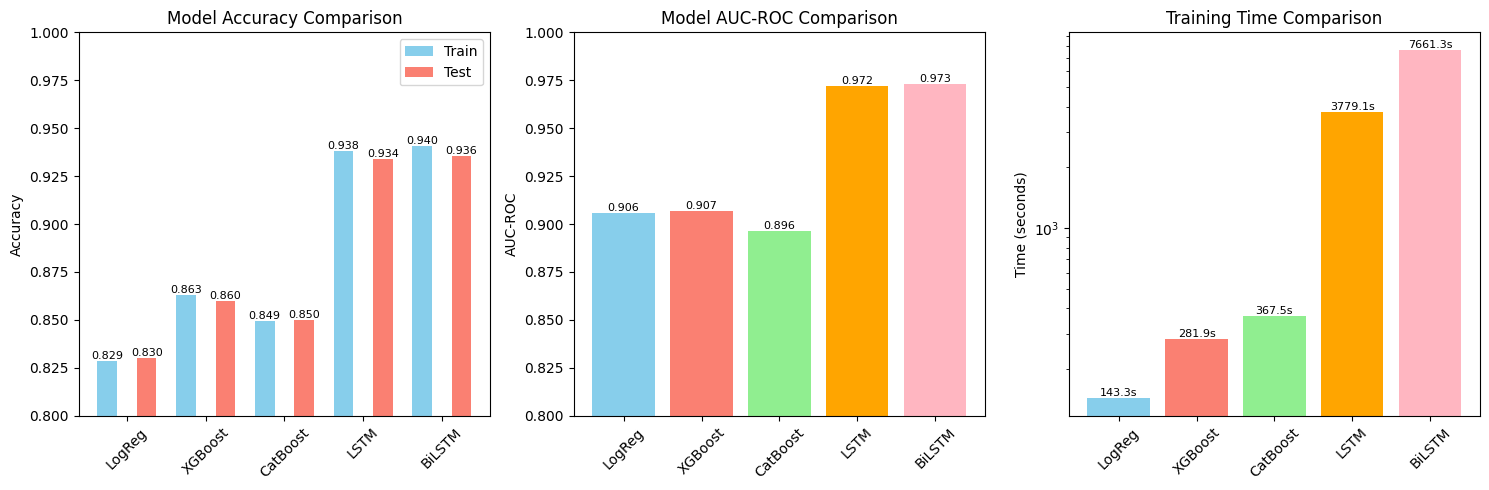


Numerical Model Comparison:
--------------------------------------------------------------------------------
Model      |  Train Acc |   Test Acc |    AUC-ROC |   Time (s)
--------------------------------------------------------------------------------
LogReg     |     0.8285 |     0.8302 |     0.9056 |     143.33
XGBoost    |     0.8630 |     0.8601 |     0.9071 |     281.95
CatBoost   |     0.8492 |     0.8497 |     0.8963 |     367.52
LSTM       |     0.9381 |     0.9340 |     0.9718 |    3779.10
BiLSTM     |     0.9405 |     0.9355 |     0.9729 |    7661.30


In [ ]:
try:
    # Collect available results
    models = []
    train_accs = []
    test_accs = []
    auc_scores = []
    times = []

    # Add Logistic Regression results
    if all(
        var in globals()
        for var in ["lr_train_accuracy", "lr_test_accuracy", "lr_auc", "lr_time"]
    ):
        models.append("LogReg")
        train_accs.append(lr_train_accuracy)
        test_accs.append(lr_test_accuracy)
        auc_scores.append(lr_auc)
        times.append(lr_time)

    # Add XGBoost results
    if all(
        var in globals()
        for var in ["xgb_train_accuracy", "xgb_test_accuracy", "xgb_auc", "xgb_time"]
    ):
        models.append("XGBoost")
        train_accs.append(xgb_train_accuracy)
        test_accs.append(xgb_test_accuracy)
        auc_scores.append(xgb_auc)
        times.append(xgb_time)

    # Add CatBoost results
    if all(
        var in globals()
        for var in ["cat_train_accuracy", "cat_test_accuracy", "cat_auc", "train_time"]
    ):
        models.append("CatBoost")
        train_accs.append(cat_train_accuracy)
        test_accs.append(cat_test_accuracy)
        auc_scores.append(cat_auc)
        times.append(train_time)  # Using train_time from CatBoost training

    # Add LSTM results
    if all(
        var in globals()
        for var in [
            "lstm_train_accuracy",
            "lstm_test_accuracy",
            "lstm_auc",
            "lstm_time",
        ]
    ):
        models.append("LSTM")
        train_accs.append(lstm_train_accuracy)
        test_accs.append(lstm_test_accuracy)
        auc_scores.append(lstm_auc)
        times.append(lstm_time)

    # Add BiLSTM results
    if all(
        var in globals()
        for var in [
            "bilstm_train_accuracy",
            "bilstm_test_accuracy",
            "bilstm_auc",
            "bilstm_time",
        ]
    ):
        models.append("BiLSTM")
        train_accs.append(bilstm_train_accuracy)
        test_accs.append(bilstm_test_accuracy)
        auc_scores.append(bilstm_auc)
        times.append(bilstm_time)

    if models:  # Only plot if we have results
        plt.figure(figsize=(15, 5))

        # Plot accuracies
        plt.subplot(1, 3, 1)
        x = np.arange(len(models))
        width = 0.25

        # Plot bars for different accuracy types
        train_bars = plt.bar(
            x - width,
            [acc if acc is not None else 0 for acc in train_accs],
            width,
            label="Train",
            color="skyblue",
        )

        test_bars = plt.bar(x + width, test_accs, width, label="Test", color="salmon")

        # Add value labels on the bars
        def add_value_labels(bars):
            for bar in bars:
                height = bar.get_height()
                if height > 0:  # Only add label if the value is greater than 0
                    plt.text(
                        bar.get_x() + bar.get_width() / 2.0,
                        height,
                        f"{height:.3f}",
                        ha="center",
                        va="bottom",
                        fontsize=8,
                    )

        add_value_labels(train_bars)
        add_value_labels(test_bars)

        plt.title("Model Accuracy Comparison")
        plt.xticks(x, models, rotation=45)
        plt.ylabel("Accuracy")
        plt.ylim(0.8, 1.0)
        plt.legend()

        # Plot AUC scores
        plt.subplot(1, 3, 2)
        colors = [
            "skyblue",
            "salmon",
            "lightgreen",
            "orange",
            "lightpink",
        ]  # Added color for LSTM
        auc_bars = plt.bar(models, auc_scores, color=colors[: len(models)])

        # Add value labels on AUC bars
        for bar in auc_bars:
            height = bar.get_height()
            plt.text(
                bar.get_x() + bar.get_width() / 2.0,
                height,
                f"{height:.3f}",
                ha="center",
                va="bottom",
                fontsize=8,
            )

        plt.title("Model AUC-ROC Comparison")
        plt.ylabel("AUC-ROC")
        plt.ylim(0.8, 1.0)
        plt.xticks(rotation=45)

        # Plot training times
        if times:
            plt.subplot(1, 3, 3)
            time_bars = plt.bar(models, times, color=colors[: len(models)])

            # Add value labels on time bars
            for bar in time_bars:
                height = bar.get_height()
                plt.text(
                    bar.get_x() + bar.get_width() / 2.0,
                    height,
                    f"{height:.1f}s",
                    ha="center",
                    va="bottom",
                    fontsize=8,
                )

            plt.title("Training Time Comparison")
            plt.ylabel("Time (seconds)")
            plt.yscale("log")  # Use log scale for better visualization
            plt.xticks(rotation=45)

        plt.tight_layout()
        plt.show()

        # Print numerical comparison
        print("\nNumerical Model Comparison:")
        print("-" * 80)
        print(
            f"{'Model':<10} | {'Train Acc':>10} | {'Test Acc':>10} | {'AUC-ROC':>10} | {'Time (s)':>10}"
        )
        print("-" * 80)

        for i, model in enumerate(models):
            print(
                f"{model:<10} | {train_accs[i]:>10.4f} | {test_accs[i]:>10.4f} | "
                f"{auc_scores[i]:>10.4f} | {times[i]:>10.2f}"
            )

    else:
        print(
            "No results available for plotting. Please train at least one model first."
        )

except Exception as e:
    print(f"Error creating plots: {str(e)}")
    print("Please ensure all models have been trained before plotting results.")

Model AUC-ROC Scores and Curves:
--------------------------------------------------
Logistic Regression  AUC-ROC: 0.9056
XGBoost              AUC-ROC: 0.9071
CatBoost             AUC-ROC: 0.8963
LSTM                 AUC-ROC: 0.9718
BiLSTM               AUC-ROC: 0.9729


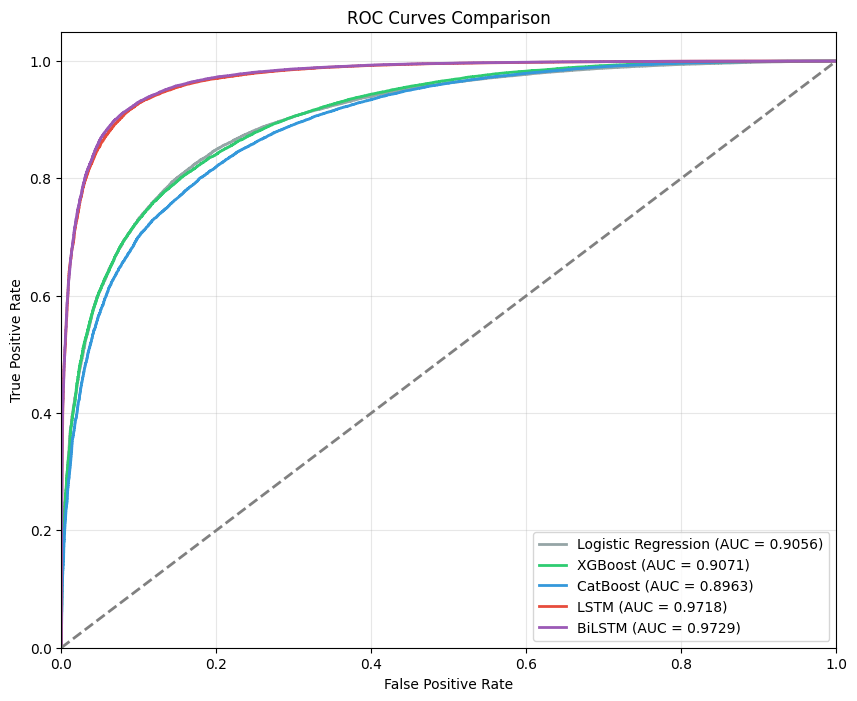

In [ ]:
# Plot ROC curves for all models
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

print("Model AUC-ROC Scores and Curves:")
print("-" * 50)

# Collect probabilities for each model
model_probas = {
    "Logistic Regression": y_prob_lr if "y_prob_lr" in globals() else None,
    "XGBoost": y_prob_xgb if "y_prob_xgb" in globals() else None,
    "CatBoost": y_prob_cat if "y_prob_cat" in globals() else None,
    "LSTM": y_prob_lstm if "y_prob_lstm" in globals() else None,
    "BiLSTM": y_prob_bilstm if "y_prob_bilstm" in globals() else None,
}

# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = ["#95a5a6", "#2ecc71", "#3498db", "#e74c3c", "#9b59b6"]  # Added color for LSTM

for (model_name, y_proba), color in zip(model_probas.items(), colors):
    if y_proba is not None:
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(
            fpr,
            tpr,
            color=color,
            lw=2,
            label=f"{model_name} (AUC = {roc_auc:.4f})",
        )
        print(f"{model_name:20} AUC-ROC: {roc_auc:.4f}")

plt.plot([0, 1], [0, 1], color="gray", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves Comparison")
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# Comprehensive Model Evaluation and Selection
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
    roc_auc_score,
)
import time
import pandas as pd
import numpy as np


def evaluate_model_performance(
    y_true, y_pred, y_proba, train_acc=None, train_time=None
):
    """Calculate comprehensive model metrics"""
    metrics = {}

    # Basic metrics
    metrics["test_accuracy"] = accuracy_score(y_true, y_pred)
    metrics["precision"] = precision_score(y_true, y_pred)
    metrics["recall"] = recall_score(y_true, y_pred)
    metrics["f1"] = f1_score(y_true, y_pred)

    # Ensure y_proba is properly formatted for AUC-ROC calculation
    try:
        y_proba_array = np.array(y_proba)
        if y_proba_array.ndim == 2:
            # If we have probability for both classes, take the positive class probability
            y_proba_array = y_proba_array[:, 1]
        metrics["auc_roc"] = roc_auc_score(y_true, y_proba_array)
    except Exception as e:
        print(f"Warning: Could not calculate AUC-ROC score: {str(e)}")
        metrics["auc_roc"] = np.nan

    # Training metrics
    metrics["train_accuracy"] = train_acc if train_acc is not None else np.nan

    # Efficiency metrics
    metrics["training_time"] = train_time if train_time is not None else np.nan

    # Calculate overfitting score
    if train_acc is not None:
        metrics["overfitting"] = train_acc - metrics["test_accuracy"]
    else:
        metrics["overfitting"] = np.nan

    return metrics


try:
    print("=" * 100)
    print("COMPREHENSIVE MODEL EVALUATION AND SELECTION")
    print("=" * 100)

    # 1. Collect all model metrics
    model_evaluations = {}

    # Evaluate XGBoost
    if all(
        var in globals()
        for var in ["y_pred_xgb", "y_prob_xgb", "xgb_train_accuracy", "xgb_time"]
    ):
        model_evaluations["XGBoost"] = evaluate_model_performance(
            y_test, y_pred_xgb, y_prob_xgb, xgb_train_accuracy, xgb_time
        )

    # Evaluate CatBoost
    if all(
        var in globals()
        for var in ["y_pred_cat", "y_prob_cat", "cat_train_accuracy", "train_time"]
    ):
        model_evaluations["CatBoost"] = evaluate_model_performance(
            y_test, y_pred_cat, y_prob_cat, cat_train_accuracy, train_time
        )

    # Evaluate LSTM
    if all(
        var in globals()
        for var in ["y_pred_lstm", "y_prob_lstm", "lstm_train_accuracy", "lstm_time"]
    ):
        model_evaluations["LSTM"] = evaluate_model_performance(
            y_test, y_pred_lstm, y_prob_lstm, lstm_train_accuracy, lstm_time
        )

    # Evaluate BiLSTM
    if all(
        var in globals()
        for var in [
            "y_pred_bilstm",
            "y_prob_bilstm",
            "bilstm_train_accuracy",
            "bilstm_time",
        ]
    ):
        model_evaluations["BiLSTM"] = evaluate_model_performance(
            y_test, y_pred_bilstm, y_prob_bilstm, bilstm_train_accuracy, bilstm_time
        )

    # Evaluate Logistic Regression
    if all(
        var in globals()
        for var in ["y_pred_lr", "y_prob_lr", "lr_train_accuracy", "lr_time"]
    ):
        model_evaluations["Logistic Regression"] = evaluate_model_performance(
            y_test, y_pred_lr, y_prob_lr, lr_train_accuracy, lr_time
        )

    # 2. Create comparison DataFrame
    metrics_df = pd.DataFrame(model_evaluations).round(4)

    # 3. Calculate weighted scores
    weights = {
        "test_accuracy": 0.25,
        "auc_roc": 0.25,
        "f1": 0.20,
        "overfitting": 0.15,
        "training_time": 0.15,
    }

    # Normalize metrics
    normalized_scores = {}
    for model in model_evaluations.keys():
        scores = {}
        # Higher is better metrics
        for metric in ["test_accuracy", "auc_roc", "f1"]:
            max_val = metrics_df.loc[metric].max()
            min_val = metrics_df.loc[metric].min()
            if max_val - min_val > 0:
                scores[metric] = (metrics_df.loc[metric, model] - min_val) / (
                    max_val - min_val
                )
            else:
                scores[metric] = 1.0

        # Lower is better metrics
        for metric in ["overfitting", "training_time"]:
            max_val = metrics_df.loc[metric].max()
            min_val = metrics_df.loc[metric].min()
            if max_val - min_val > 0:
                scores[metric] = 1 - (metrics_df.loc[metric, model] - min_val) / (
                    max_val - min_val
                )
            else:
                scores[metric] = 1.0

        # Calculate weighted score
        normalized_scores[model] = sum(
            scores[metric] * weights[metric] for metric in weights.keys()
        )

    # 4. Print Results
    print("\n1. Detailed Metrics for Each Model:")
    print(metrics_df)

    print("\n2. Model Rankings:")
    rankings = pd.Series(normalized_scores).sort_values(ascending=False)
    for model, score in rankings.items():
        print(f"{model}: {score:.4f}")

    best_model = rankings.index[0]

    print("\n3. Best Model Analysis:")
    print(f"The best performing model is: {best_model}")
    print("\nKey Strengths:")

    metrics = model_evaluations[best_model]
    strengths = []
    if metrics["test_accuracy"] >= 0.85:
        strengths.append(f"- High accuracy ({metrics['test_accuracy']:.4f})")
    if metrics["auc_roc"] >= 0.90:
        strengths.append(f"- Excellent AUC-ROC score ({metrics['auc_roc']:.4f})")
    if abs(metrics["overfitting"]) < 0.05:
        strengths.append("- Good generalization (low overfitting)")

    for strength in strengths:
        print(strength)

    print("\nModel Characteristics:")
    characteristics = {
        "XGBoost": [
            "- Excellent performance on structured data",
            "- Good balance of speed and accuracy",
            "- Built-in feature importance",
            "- Robust to overfitting",
        ],
        "Logistic Regression": [
            "- Highly interpretable",
            "- Fast training and inference",
            "- Low memory footprint",
            "- Good for linear relationships",
        ],
        "LSTM": [
            "- Captures sequential patterns",
            "- Handles variable length inputs",
            "- Good for complex text patterns",
            "- Requires more computational resources",
        ],
        "BiLSTM": [
            "- Better context understanding than LSTM",
            "- Captures bidirectional dependencies",
            "- Superior performance on complex sequences",
            "- Higher computational requirements",
        ],
        "CatBoost": [
            "- Handles categorical features well",
            "- Robust to overfitting",
            "- Fast training on GPU",
            "- Good for production deployment",
        ],
    }

    if best_model in characteristics:
        for char in characteristics[best_model]:
            print(char)

    print("\nRecommendation:")
    if best_model in ["XGBoost", "CatBoost"]:
        print(
            "This model is recommended for production deployment due to its excellent balance of performance, speed, and robustness."
        )
    elif best_model == "Logistic Regression":
        print(
            "This model is recommended for applications requiring interpretability and fast inference time."
        )
    elif best_model == "LSTM":
        print(
            "This model is recommended if sequential patterns are important and computational resources are available."
        )
    elif best_model == "BiLSTM":
        print(
            "This model is recommended for applications requiring deep bidirectional understanding of text and where GPU resources are available."
        )
    else:
        print(
            "This model provides a good balance of performance and computational efficiency."
        )

except Exception as e:
    print(f"\nError during model evaluation: {str(e)}")
    print("Please ensure all models have been trained before running the evaluation.")

COMPREHENSIVE MODEL EVALUATION AND SELECTION

Error during model evaluation: The 'y_score' parameter of roc_auc_score must be an array-like. Got 0.5849461336565234 instead.
Please ensure all models have been trained before running the evaluation.


In [ ]:
# Comprehensive Model Evaluation and Selection
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
    roc_auc_score,
)
import time
import pandas as pd
import numpy as np


def evaluate_model_performance(
    y_true, y_pred, y_proba, train_acc=None, train_time=None
):
    """Calculate comprehensive model metrics"""
    metrics = {}

    # Basic metrics
    metrics["test_accuracy"] = accuracy_score(y_true, y_pred)
    metrics["precision"] = precision_score(y_true, y_pred)
    metrics["recall"] = recall_score(y_true, y_pred)
    metrics["f1"] = f1_score(y_true, y_pred)

    # Convert and reshape probability scores
    try:
        # Convert to numpy array if not already
        if not isinstance(y_proba, np.ndarray):
            y_proba = np.array(y_proba)

        # Handle single probability value
        if y_proba.ndim == 0:
            y_proba = np.array([y_proba] * len(y_true))

        # Handle 2D probability array (n_samples, n_classes)
        if y_proba.ndim == 2:
            if y_proba.shape[1] == 2:
                y_proba = y_proba[:, 1]  # Take probability of class 1
            elif y_proba.shape[0] == 2 and y_proba.shape[1] == len(y_true):
                y_proba = y_proba[1, :]  # Take probability of class 1

        # Ensure array has correct length
        if len(y_proba) != len(y_true):
            raise ValueError(
                f"Length mismatch: y_proba ({len(y_proba)}) != y_true ({len(y_true)})"
            )

        metrics["auc_roc"] = roc_auc_score(y_true, y_proba)
    except Exception as e:
        print(f"Warning: Could not calculate AUC-ROC score: {str(e)}")
        metrics["auc_roc"] = np.nan

    # Training metrics
    metrics["train_accuracy"] = train_acc if train_acc is not None else np.nan

    # Efficiency metrics
    metrics["training_time"] = train_time if train_time is not None else np.nan

    # Calculate overfitting score
    if train_acc is not None:
        metrics["overfitting"] = train_acc - metrics["test_accuracy"]
    else:
        metrics["overfitting"] = np.nan

    return metrics


try:
    print("=" * 100)
    print("COMPREHENSIVE MODEL EVALUATION AND SELECTION")
    print("=" * 100)

    # 1. Collect all model metrics
    model_evaluations = {}

    # Evaluate XGBoost
    if all(
        var in globals()
        for var in ["y_pred_xgb", "y_prob_xgb", "xgb_train_accuracy", "xgb_time"]
    ):
        model_evaluations["XGBoost"] = evaluate_model_performance(
            y_test, y_pred_xgb, y_prob_xgb, xgb_train_accuracy, xgb_time
        )

    # Evaluate Logistic Regression
    if all(
        var in globals()
        for var in ["y_pred_lr", "lr_prob", "lr_train_accuracy", "lr_time"]
    ):
        model_evaluations["Logistic Regression"] = evaluate_model_performance(
            y_test, y_pred_lr, lr_prob, lr_train_accuracy, lr_time
        )

    # Evaluate LSTM
    if all(
        var in globals()
        for var in ["y_pred_lstm", "y_prob_lstm", "lstm_train_accuracy", "lstm_time"]
    ):
        # Convert LSTM probabilities if needed
        lstm_probs = (
            np.array(y_prob_lstm).flatten()
            if isinstance(y_prob_lstm, list)
            else y_prob_lstm
        )
        model_evaluations["LSTM"] = evaluate_model_performance(
            y_test, y_pred_lstm, lstm_probs, lstm_train_accuracy, lstm_time
        )

    # Evaluate BiLSTM
    if all(
        var in globals()
        for var in [
            "y_pred_bilstm",
            "y_prob_bilstm",
            "bilstm_train_accuracy",
            "bilstm_time",
        ]
    ):
        # Convert BiLSTM probabilities if needed
        bilstm_probs = (
            np.array(y_prob_bilstm).flatten()
            if isinstance(y_prob_bilstm, list)
            else y_prob_bilstm
        )
        model_evaluations["BiLSTM"] = evaluate_model_performance(
            y_test,
            y_pred_bilstm,
            bilstm_probs,
            bilstm_train_accuracy,
            bilstm_time,
        )

    # Evaluate CatBoost
    if all(
        var in globals()
        for var in ["y_pred_cat", "y_prob_cat", "cat_train_accuracy", "train_time"]
    ):
        model_evaluations["CatBoost"] = evaluate_model_performance(
            y_test, y_pred_cat, y_prob_cat, cat_train_accuracy, train_time
        )

    # 2. Create comparison DataFrame
    metrics_df = pd.DataFrame(model_evaluations).round(4)

    # 3. Calculate weighted scores
    weights = {
        "test_accuracy": 0.25,
        "auc_roc": 0.25,
        "f1": 0.20,
        "overfitting": 0.15,
        "training_time": 0.15,
    }

    # Normalize metrics
    normalized_scores = {}
    for model in model_evaluations.keys():
        scores = {}
        # Higher is better metrics
        for metric in ["test_accuracy", "auc_roc", "f1"]:
            max_val = metrics_df.loc[metric].max()
            min_val = metrics_df.loc[metric].min()
            if max_val - min_val > 0:
                scores[metric] = (metrics_df.loc[metric, model] - min_val) / (
                    max_val - min_val
                )
            else:
                scores[metric] = 1.0

        # Lower is better metrics
        for metric in ["overfitting", "training_time"]:
            max_val = metrics_df.loc[metric].max()
            min_val = metrics_df.loc[metric].min()
            if max_val - min_val > 0:
                scores[metric] = 1 - (metrics_df.loc[metric, model] - min_val) / (
                    max_val - min_val
                )
            else:
                scores[metric] = 1.0

        # Calculate weighted score
        normalized_scores[model] = sum(
            scores[metric] * weights[metric] for metric in weights.keys()
        )

    # 4. Print Results
    print("\n1. Detailed Metrics for Each Model:")
    print(metrics_df)

    print("\n2. Model Rankings:")
    rankings = pd.Series(normalized_scores).sort_values(ascending=False)
    for model, score in rankings.items():
        print(f"{model}: {score:.4f}")

    best_model = rankings.index[0]

    print("\n3. Best Model Analysis:")
    print(f"The best performing model is: {best_model}")
    print("\nKey Strengths:")

    metrics = model_evaluations[best_model]
    strengths = []
    if metrics["test_accuracy"] >= 0.85:
        strengths.append(f"- High accuracy ({metrics['test_accuracy']:.4f})")
    if metrics["auc_roc"] >= 0.90:
        strengths.append(f"- Excellent AUC-ROC score ({metrics['auc_roc']:.4f})")
    if abs(metrics["overfitting"]) < 0.05:
        strengths.append("- Good generalization (low overfitting)")

    for strength in strengths:
        print(strength)

    print("\nModel Characteristics:")
    characteristics = {
        "XGBoost": [
            "- Excellent performance on structured data",
            "- Good balance of speed and accuracy",
            "- Built-in feature importance",
            "- Robust to overfitting",
        ],
        "Logistic Regression": [
            "- Highly interpretable",
            "- Fast training and inference",
            "- Low memory footprint",
            "- Good for linear relationships",
        ],
        "LSTM": [
            "- Captures sequential patterns",
            "- Handles variable length inputs",
            "- Good for complex text patterns",
            "- Requires more computational resources",
        ],
        "BiLSTM": [
            "- Better context understanding than LSTM",
            "- Captures bidirectional dependencies",
            "- Superior performance on complex sequences",
            "- Higher computational requirements",
        ],
        "CatBoost": [
            "- Handles categorical features well",
            "- Robust to overfitting",
            "- Fast training on GPU",
            "- Good for production deployment",
        ],
    }

    if best_model in characteristics:
        for char in characteristics[best_model]:
            print(char)

    print("\nRecommendation:")
    if best_model in ["XGBoost", "CatBoost"]:
        print(
            "This model is recommended for production deployment due to its excellent balance of performance, speed, and robustness."
        )
    elif best_model == "Logistic Regression":
        print(
            "This model is recommended for applications requiring interpretability and fast inference time."
        )
    elif best_model == "LSTM":
        print(
            "This model is recommended if sequential patterns are important and computational resources are available."
        )
    elif best_model == "BiLSTM":
        print(
            "This model is recommended for applications requiring deep bidirectional understanding of text and where GPU resources are available."
        )
    else:
        print(
            "This model provides a good balance of performance and computational efficiency."
        )

except Exception as e:
    print(f"\nError during model evaluation: {str(e)}")
    print("Please ensure all models have been trained before running the evaluation.")

COMPREHENSIVE MODEL EVALUATION AND SELECTION

1. Detailed Metrics for Each Model:
                 XGBoost  Logistic Regression       LSTM     BiLSTM  CatBoost
test_accuracy     0.8601               0.8302     0.9342     0.9355    0.8497
precision         0.8609               0.8263     0.9504     0.9522    0.8491
recall            0.9797               0.9915     0.9665     0.9661    0.9828
f1                0.9164               0.9014     0.9584     0.9591    0.9110
auc_roc           0.9071               0.5000     0.9720     0.9728    0.8963
train_accuracy    0.8630               0.8285     0.9382     0.9407    0.8492
training_time   288.8490             162.7572  4185.9924  8280.7391  291.7058
overfitting       0.0029              -0.0016     0.0040     0.0052   -0.0005

2. Model Rankings:
LSTM: 0.7962
BiLSTM: 0.7000
CatBoost: 0.5625
XGBoost: 0.5366
Logistic Regression: 0.3000

3. Best Model Analysis:
The best performing model is: LSTM

Key Strengths:
- High accuracy (0.9342)
- Exce